In [12]:
# STEP 1: Imports
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/dipanshuparashar/Library/CloudStorage/OneDrive-UNTSystem/DESKTOP/Project/Bank_Transactional_data/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


📌 FraudRiskLevel Mapping:
{'High': np.int64(0), 'Low': np.int64(1), 'Moderate': np.int64(2)}
🔎 Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.82      0.90       322
         Low       0.84      1.00      0.91       302
    Moderate       1.00      1.00      1.00       130

    accuracy                           0.92       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.93      0.92      0.92       754

📊 Confusion Matrix:


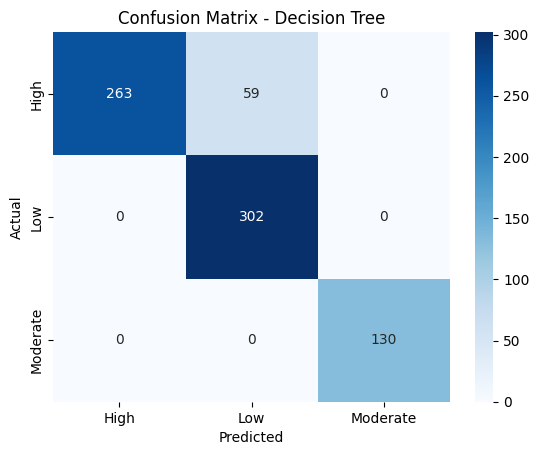

In [2]:
# === Step 2: Load Data ===
df_train = pd.read_csv('../data/processed/fraud_train_data.csv')
df_test  = pd.read_csv('../data/processed/fraud_test_data.csv')

# === Step 3: Encode Categorical Features ===
categorical_cols = ['TransactionType', 'Channel', 'CustomerOccupation', 'Location']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))
    label_encoders[col] = le

# === Step 4: Encode Target Column ===
target_encoder = LabelEncoder()
df_train['FraudRiskEncoded'] = target_encoder.fit_transform(df_train['FraudRiskLevel'])
df_test['FraudRiskEncoded'] = target_encoder.transform(df_test['FraudRiskLevel'])

print("📌 FraudRiskLevel Mapping:")
print(dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_))))

# === Step 5: Define Features and Target ===
drop_cols = ['TransactionID', 'AccountID', 'TransactionDate', 'PreviousTransactionDate',
             'IP Address', 'DeviceID', 'MerchantID', 'FraudRiskLevel', 'FraudRiskEncoded', 'Cluster']

X_train = df_train.drop(columns=drop_cols)
y_train = df_train['FraudRiskEncoded']

X_test = df_test.drop(columns=drop_cols)
y_test = df_test['FraudRiskEncoded']

# === Step 6: Train Decision Tree Classifier ===
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# === Step 7: Evaluate ===
y_pred = dt_model.predict(X_test)

print("🔎 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

print("📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


 Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.91      0.95       322
         Low       0.91      1.00      0.95       302
    Moderate       1.00      1.00      1.00       130

    accuracy                           0.96       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.96      0.96      0.96       754


 Confusion Matrix:


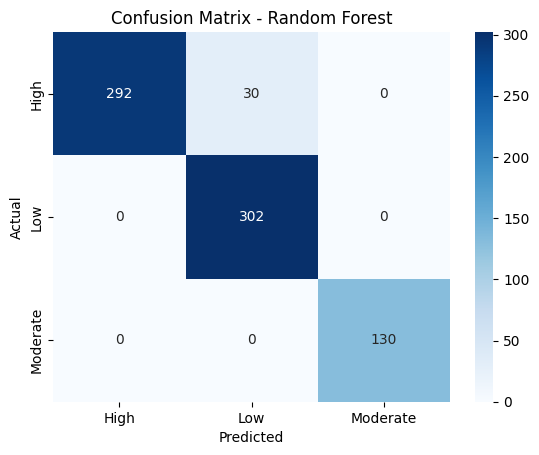

In [3]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=42)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, rf_y_pred, target_names=target_encoder.classes_))

# 4. Confusion matrix
print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

/var/folders/xy/4dlq6j496mn3pkkcn0bzhj0r0000gp/T/ipykernel_2552/845407179.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='Blues_d')


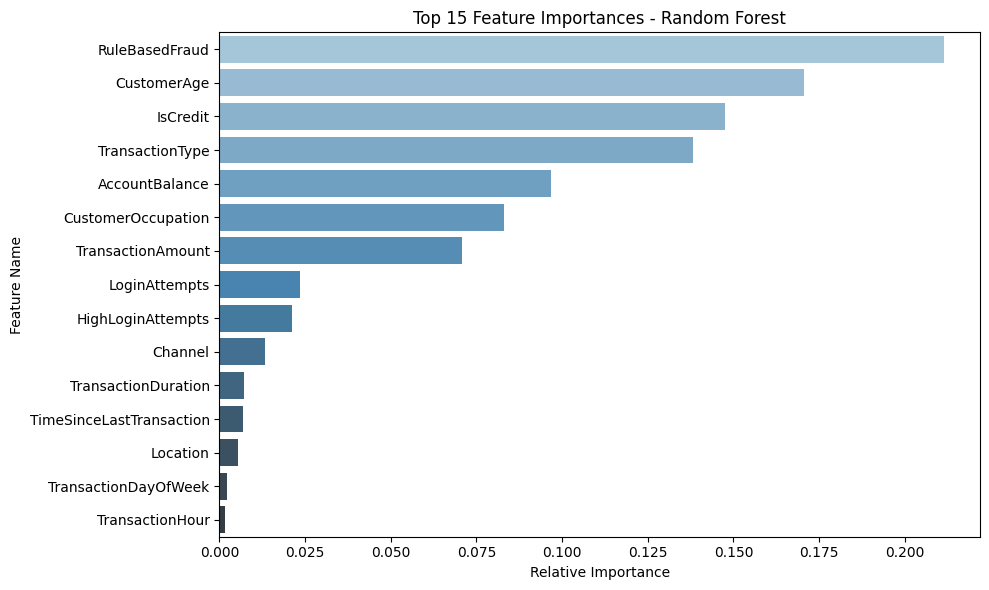

In [7]:


# Get feature importances
importances = rf_model.feature_importances_

# Match to column names
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='Blues_d')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


In [9]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create base model
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1_weighted',
    verbose=2
)

# Run GridSearch
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

📊 Tuned Model Report:
              precision    recall  f1-score   support

        High       1.00      0.95      0.97       322
         Low       0.95      1.00      0.97       302
    Moderate       1.00      1.00      1.00       130

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98      0.98      0.98       754



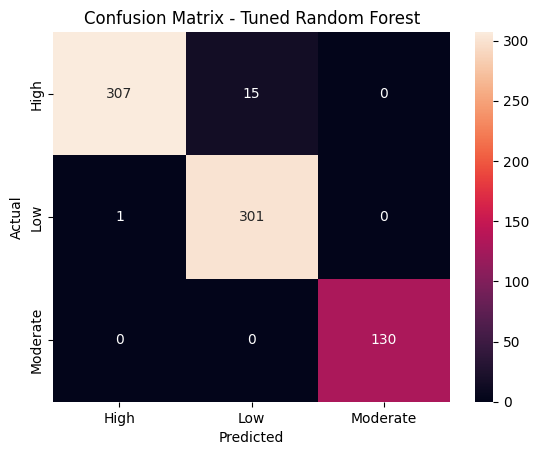

In [10]:
# Predict
y_pred_rfb = best_rf.predict(X_test)

# Report
print("📊 Tuned Model Report:")
print(classification_report(y_test, y_pred_rfb, target_names=target_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rfb)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()